## Cifar10 with MC-Dropout

In this notebook we will use again the cifar 10 dataset. We will use only 2 of the 10 labels to train a CNN and use Dropout not only in the training but also at test-time. The labels for the trainig will be only airplane and automobile, but we will predict all ten labels! The goal is find a method to distinglish between known and unknown labels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf 
import keras

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


#### Make train and testset smaller


In [3]:
#loop over each class label and sample random images over each label and save the idx to subset
np.random.seed(seed=220)
idx=np.empty(0,dtype="int8")
for i in range(0,len(np.unique(y_train))):
    idx=np.append(idx,np.random.choice(np.where((y_train[0:len(y_train)])==i)[0],1000,replace=False))

x_train= x_train[idx]
y_train= y_train[idx]

In [4]:
#loop over each class label and sample random images over each label and save the idx to subset
np.random.seed(seed=220)
idx=np.empty(0,dtype="int8")
for i in range(0,len(np.unique(y_test))):
    idx=np.append(idx,np.random.choice(np.where((y_test[0:len(y_test)])==i)[0],250,replace=False))

x_test= x_test[idx]
y_test= y_test[idx]

In [5]:
print(x_train.shape)
print(y_train.shape)
print(np.unique(y_train,return_counts=True))
print(x_test.shape)
print(y_test.shape)
print(np.unique(y_test,return_counts=True))

(10000, 32, 32, 3)
(10000, 1)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))
(2500, 32, 32, 3)
(2500, 1)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([250, 250, 250, 250, 250, 250, 250, 250, 250, 250]))


In [6]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])

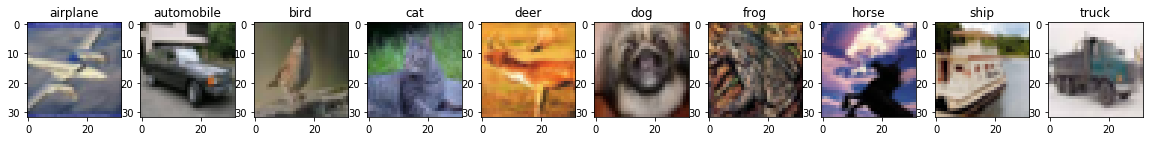

In [7]:
#sample image of each label
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i])

#### Delete all labels, except 0 and 1 (airplane and automobile)

In [8]:
idx=np.where(np.in1d(y_train,[2,3,4,5,6,7,8,9]))[0]
len(idx)

8000

In [9]:
x_train=np.delete(x_train,idx,axis=0)
y_train=np.delete(y_train,idx,axis=0)

In [10]:
print(x_train.shape)
print(y_train.shape)

(2000, 32, 32, 3)
(2000, 1)


#### Normalize the train and testdata


In [11]:
X_mean = np.mean( x_train, axis = 0)
X_std = np.std( x_train, axis = 0)

x_train = (x_train - X_mean ) / (X_std + 0.0001)
x_test = (x_test - X_mean ) / (X_std + 0.0001)

In [12]:
print(np.unique(y_train))
labels[np.unique(y_train)]

[0 1]


array(['airplane', 'automobile'], dtype='<U10')

In [13]:
from keras.utils.np_utils import to_categorical   

y_train=to_categorical(y_train,2)

#### Split trainingdata into a tran and validset

In [14]:
#make 80% train and 20% valid out of train
np.random.seed(478)
rand_idx=np.random.choice(list(range(0,len(x_train))),replace=False,size=round(0.8*(len(x_train))))
len(rand_idx)

1600

In [15]:
x_valid=np.delete(x_train,axis=0,obj=rand_idx)
y_valid=np.delete(y_train,axis=0,obj=rand_idx)

In [16]:
x_train=x_train[rand_idx]
y_train=y_train[rand_idx]

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)


(1600, 32, 32, 3)
(1600, 2)
(400, 32, 32, 3)
(400, 2)


#### Define and train the model


In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Lambda

In [19]:
np.transpose(np.unique(np.argmax(y_train,axis=1),return_counts=True))

array([[  0, 812],
       [  1, 788]])

In [20]:
# mc-dropout function
def mcdrop(x, level=0.3):
  return K.dropout(x, level=level)

In [21]:
model = Sequential()
name = 'cifar_1'


model.add(Convolution2D(16, (3,3),padding='same',input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Convolution2D(16, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
   
model.add(Lambda(mcdrop, name="MC-Dropout_1"))
model.add(Dense(400))

model.add(Activation('relu'))

model.add(Lambda(mcdrop, name="MC-Dropout_2"))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
activation_3 (Activation)    (None, 16, 16, 32)        0         
__________

In [23]:
history = model.fit(x_train,y_train,
                    batch_size=128,
                    epochs = 15,                    
                    validation_data = (x_valid, y_valid),
                    verbose = 1)

Instructions for updating:
Use tf.cast instead.
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 5s 3ms/step - loss: 0.5947 - acc: 0.6806 - val_loss: 0.5162 - val_acc: 0.7750
Epoch 2/15
1600/1600 [==============================] - 5s 3ms/step - loss: 0.4824 - acc: 0.7694 - val_loss: 0.5208 - val_acc: 0.7825
Epoch 3/15
1600/1600 [==============================] - 6s 4ms/step - loss: 0.3912 - acc: 0.8194 - val_loss: 0.3943 - val_acc: 0.8300
Epoch 4/15
1600/1600 [==============================] - 5s 3ms/step - loss: 0.3068 - acc: 0.8625 - val_loss: 0.3320 - val_acc: 0.8575
Epoch 5/15
1600/1600 [==============================] - 5s 3ms/step - loss: 0.2732 - acc: 0.8806 - val_loss: 0.3147 - val_acc: 0.8725
Epoch 6/15
1600/1600 [==============================] - 6s 3ms/step - loss: 0.2269 - acc: 0.9050 - val_loss: 0.3326 - val_acc: 0.8675
Epoch 7/15
1600/1600 [==============================] - 6s 4ms/step - loss: 0.1864 - acc: 0.9194 - va

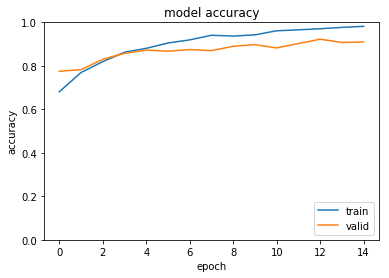

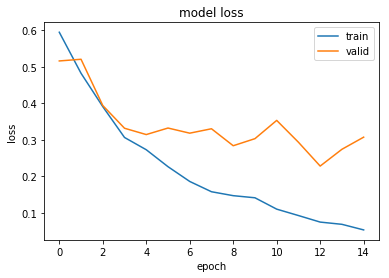

In [24]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()


#### Prediction

##### a1) Use the trained model to predict the fist image of the testset twice, and describe what you observe?
##### a2) Do the same for an image that was not used during training.

In [25]:
#predict the same image does not give the same result
#here for known label
print(labels[y_test[0]])
print(model.predict(x_test[0].reshape(1,32,32,3)))
print(model.predict(x_test[0].reshape(1,32,32,3)))

['airplane']
[[9.9970490e-01 2.9505216e-04]]
[[9.9994314e-01 5.6858822e-05]]


In [26]:
#predict the same image does not give the same result
#here for unknown label
print(labels[y_test[1000]])
print(model.predict(x_test[1000].reshape(1,32,32,3)))
print(model.predict(x_test[1000].reshape(1,32,32,3)))

['deer']
[[0.24602334 0.7539766 ]]
[[0.6437467  0.35625336]]


##### b1) Now predict the first image of the test set 500 times (what is the true label of this image?), save all predicitons and plot the predicted probability for airplane and automobile in 2 histograms. 
Hint: you might want to use the numpy function np.tile, what is this function doing?
##### b2) Use images that were not used in training and do the same as above. Are the predictions diffrent? What does it mean when you see a broad or narrow distribution?


true label
['airplane']


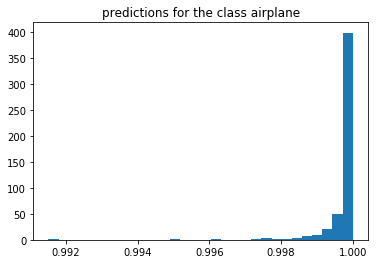

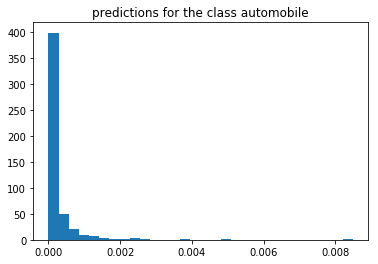

In [27]:
print("true label")
print(labels[y_test[0]])
multi_img=np.tile(x_test[0],(500,1,1,1))
preds=model.predict(multi_img)
plt.hist(preds[:,0],bins=30)
plt.title("predictions for the class airplane")
plt.show()
plt.hist(preds[:,1],bins=30)
plt.title("predictions for the class automobile")
plt.show()

true label
['ship']


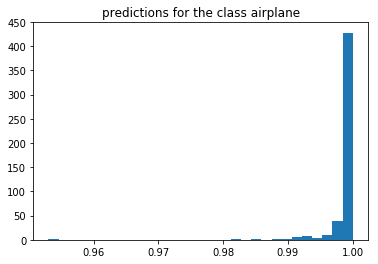

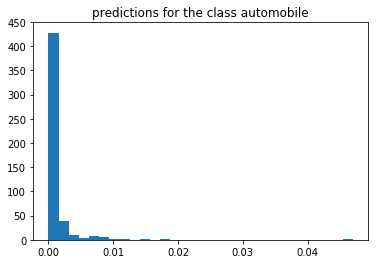

In [28]:
print("true label")
print(labels[y_test[2000]])
multi_img=np.tile(x_test[2000],(500,1,1,1))
preds=model.predict(multi_img)
plt.hist(preds[:,0],bins=30)
plt.title("predictions for the class airplane")
plt.show()
plt.hist(preds[:,1],bins=30)
plt.title("predictions for the class automobile")
plt.show()

true label
['deer']


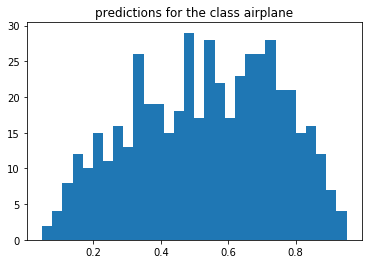

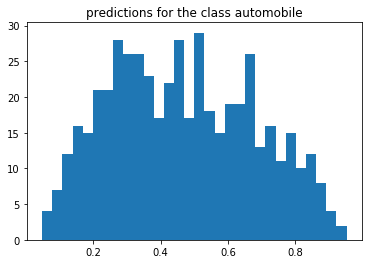

In [29]:
print("true label")
print(labels[y_test[1000]])
multi_img=np.tile(x_test[1000],(500,1,1,1))
preds=model.predict(multi_img)
plt.hist(preds[:,0],bins=30)
plt.title("predictions for the class airplane")
plt.show()
plt.hist(preds[:,1],bins=30)
plt.title("predictions for the class automobile")
plt.show()

### Filtering
In this section we want to find a way how we could filter known from unknown labels, for this we predict every image of the testset 50 times and save the mean and the standard deviation of these 50 predictions. Then we want to see if there is a difference in the predictive distributions, depending on whether we used the label in the trainig or not.

In [30]:
#predict every image 50 times and save the mean of the predictions and the standard deviation

pred_means=np.zeros((len(x_test),2))
pred_std=np.zeros((len(x_test),1))

for i in range(0,len(x_test)):
    multi_img=np.tile(x_test[i],(50,1,1,1))
    preds=model.predict(multi_img)
    pred_means[i]= np.mean(preds,axis=0)
    pred_std[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
    if i % 250 ==0:
        print(i)

0
250
500
750
1000
1250
1500
1750
2000
2250


In [31]:
idx_known = np.where(np.in1d(y_test,[0,1]))[0]
idx_unknown = np.where(np.in1d(y_test,[2,3,4,5,6,7,8,9]))[0]
print(len(idx_known))
print(len(idx_unknown))

500
2000


#### labels that were used for training
Here we plot the histograms of the means and the standard deviations for each image that we used in the trainingset.

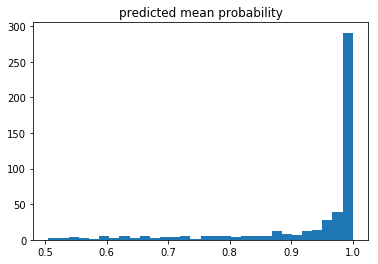

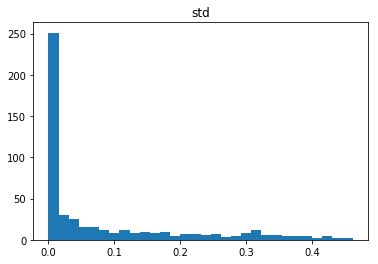

In [32]:
plt.hist(np.max(pred_means[idx_known],axis=1),bins=30)
plt.title("predicted mean probability")
plt.show()
plt.hist(pred_std[idx_known],bins=30)
plt.title("std")
plt.show()

##### c) Now, plot  the histogram of the mean values and the standard deviations for the labels that were not used in the trainingset. What do you observe when you compare the distributions of the means and the standard deviations of the known vs the unknown labels?
Hint: Look at the code above and use *idx_unknown*

#### labels that were not used for training


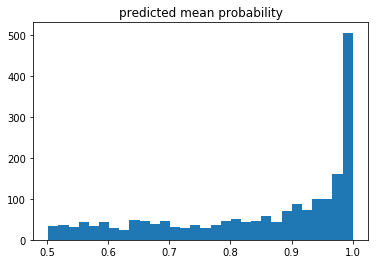

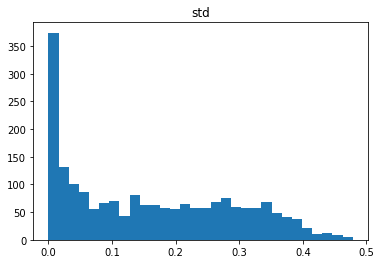

In [33]:
plt.hist(np.max(pred_means[idx_unknown],axis=1),bins=30)
plt.title("predicted mean probability")
plt.show()
plt.hist(pred_std[idx_unknown],bins=30)
plt.title("std")
plt.show()

In [34]:
#acc on the whole test dataset (max possible: 20%)
np.sum(np.argmax(pred_means,axis=1)==y_test.reshape(len(y_test)))/len(y_test)

0.184

#### Filter with std
Now we will use the images with the lowest standard deviation and calculate the accuracy on those images, we hope that images with labels that were used in the trainingset, have a lower standard deviation than images with labels that were not used in the trainingset.

##### d) Try to understand the code below and interpret the accuracy plots

In [35]:
# getting the index of the oberservation(image) with the smallest standard deviation
d = np.sum(pred_std,axis=1)
certainty_idx = np.argsort(d.reshape(len(d)))
print(certainty_idx[0:10])
print(d[certainty_idx[0:10]])

[  9 155 169 230  48  61 167  29  83 148]
[3.23533129e-08 3.71639075e-08 4.19029824e-08 4.87114491e-08
 8.40553014e-08 9.97674547e-08 3.16080246e-07 3.83770697e-07
 4.25648125e-07 4.89474189e-07]


In [36]:
def acc_for_n_best(n_best):
  return np.mean(np.argmax(pred_means[certainty_idx[0:n_best]], axis=1) == np.reshape(y_test[certainty_idx[0:n_best]], newshape=(n_best)))

In [37]:
acc_nbest = np.zeros((2500))
for nbest in range(0,2500):
  acc_nbest[nbest] = acc_for_n_best(nbest+1)

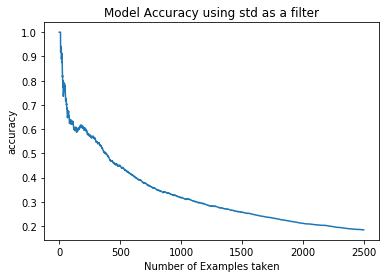

In [38]:
#plot the acc if we use the best n (1-2500) predictions (lowest std)
plt.plot(acc_nbest)
plt.title('Model Accuracy using std as a filter')
plt.ylabel('accuracy')
plt.xlabel('Number of Examples taken')
plt.show()

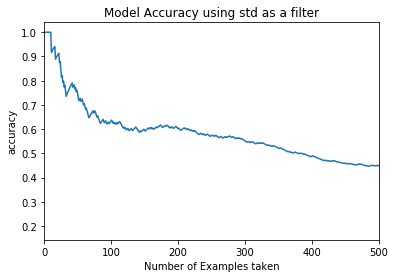

In [39]:
#plot the acc if we use the best n (1-500) predictions (lowest std)
plt.plot(acc_nbest)
plt.xlim(0, 500)
plt.title('Model Accuracy using std as a filter')
plt.ylabel('accuracy')
plt.xlabel('Number of Examples taken')
plt.show()